# Examine Clusters

In [44]:
import os
from decouple import config
import second_level_functions as slf
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

Change task and contrast to examine clusters

In [34]:
task = 'eft'
contrast = 'interaction'

Read in images and get parameter estimates

In [35]:
base_dir = config(task)
path = os.path.join(base_dir, '2ndlevel', 'mixed_model')
images = slf.get_images(path)
contrasts = slf.contrast_imgs(images['t_stat'], images['pvals'])
threshold_pval = -np.log10(0.05)
parameter_estimates_df = slf.get_parameter_estimates(contrasts[contrast]['pvals'], threshold_pval, path, base_dir)
parameter_estimates_df['mean'] = parameter_estimates_df.iloc[0:,4:].mean(axis=1)

## Plot and get mean of parameter estimates

Split parameter estimates by group and time point. Then get mean of each group and at in each time point

In [37]:
an_t1 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') & (parameter_estimates_df['time_point'] == 't1')]
an_t2 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'AN') & (parameter_estimates_df['time_point'] == 't2')]
hc_t1 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') & (parameter_estimates_df['time_point'] == 't1')]
hc_t2 = parameter_estimates_df.loc[(parameter_estimates_df['group'] == 'HC') & (parameter_estimates_df['time_point'] == 't2')]

In [39]:
means_std_df = pd.DataFrame(data={
    'AN mean':  [an_t1['mean'].mean(), an_t2['mean'].mean(), pd.concat((an_t1, an_t2))['mean'].mean()],
    'HC mean': [hc_t1['mean'].mean(), hc_t2['mean'].mean(), pd.concat((hc_t1, hc_t2))['mean'].mean()],
    'AN std': [an_t1['mean'].std(), an_t2['mean'].std(), pd.concat((an_t1, an_t2))['mean'].std()],
    'HC std': [hc_t1['mean'].std(), hc_t2['mean'].std(), pd.concat((hc_t1, hc_t2))['mean'].std()]
                   }, index=['T1', 'T2', 'Overall']) 
means_std_df

,AN mean,HC mean,AN std,HC std
T1,-0.028675,0.153115,0.116719,0.173563
T2,-0.028947,-0.180996,0.109486,0.267155
Overall,-0.028811,-0.013940,0.112721,0.279686


Plot parameter estimates

<AxesSubplot: xlabel='time_point', ylabel='mean'>

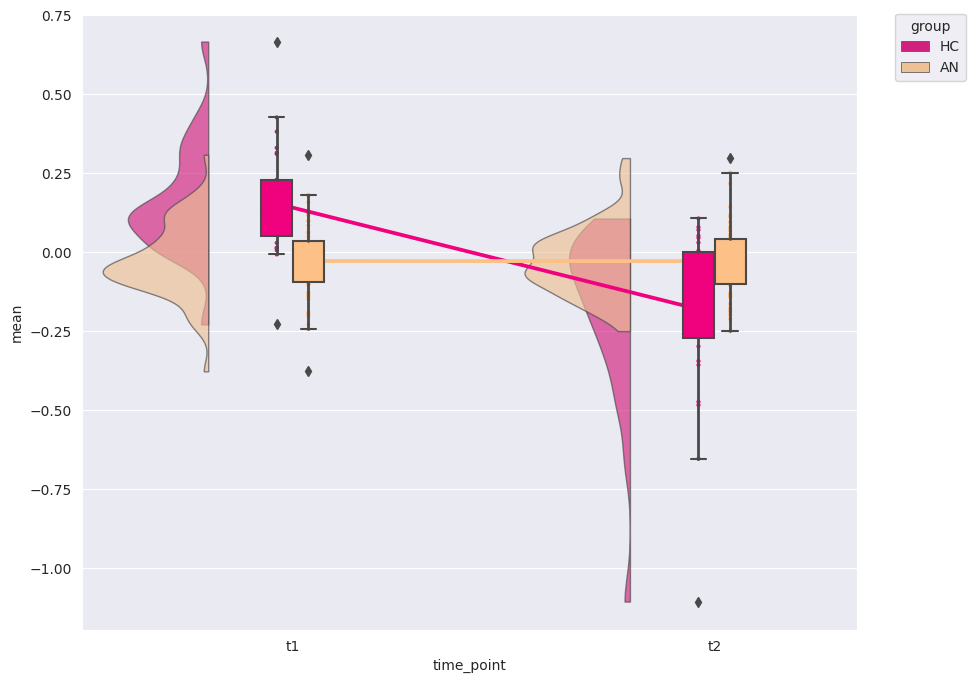

In [38]:
fig,ax = plt.subplots(1,1, figsize=(10, 8))
pt.RainCloud(
    x="time_point", 
    y="mean", 
    hue="group", 
    data=parameter_estimates_df, 
    palette='Accent_r', 
    alpha = .65, 
    dodge = True, 
    scale = "area",
    ax=ax,
    width_viol=.5,
    jitter=0,
    pointplot = True,
    bw = .3
     )



## Linear Mixed Model

Change reference level of model by changing the name of AN to participant with AN (pAN) and HC to Control

In [40]:
regression_df = parameter_estimates_df
regression_df['group'] = regression_df['group'].apply(lambda group: 'pAN' if group == 'AN' else 'Control')

define and fit the model

In [41]:
model = smf.mixedlm("mean ~ time_point + group + group*time_point", 
                    regression_df, 
                    groups=regression_df["sub"]).fit()
model.summary()

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM       Dependent Variable:       mean   
No. Observations:        184           Method:                   REML   
No. Groups:              92            Scale:                    0.0220 
Min. group size:         2             Log-Likelihood:           73.9193
Max. group size:         2             Converged:                Yes    
Mean group size:         2.0                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.153    0.030  5.161 0.000  0.095  0.211
time_point[T.t2]              -0.334    0.040 -8.274 0.000 -0.413 -0.255
group[T.pAN]                  -0.182    0.035 -5.150 0.000 -0.251 -0.113
group[T.pAN]:time_point[T.t2]  0.334    0.048  6.949 0.000  0.240  0.428
Group Var                      0.002    0.018                           
========================================================================

"""

**Bayes comparison**

Define a null model (no group just time and subject intercepts).

Then calculate the bayes factor by dividing the log likelihood of each model

In [42]:
null = smf.mixedlm("mean ~ time_point + sub:time_point", 
                    regression_df, 
                    groups=regression_df["sub"]).fit()

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [43]:
bayes_factor = model.llf / null.llf
bayes_factor

1.260248338741808